https://stats.stackexchange.com/questions/13166/rs-lmer-cheat-sheet

In [1]:
library(tidyverse)
library(magrittr)
library(readxl)
library(lmerTest)
library(emmeans)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.4     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract


Loading required package: lme4

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step




In [2]:
exp1 = read_xlsx('CLICK-it_WB_cumulative_LCLs.xlsx', sheet=1)

In [3]:
head(exp1)

Gel,Genotype,Sample,Treatment,TAMRA,BetaActin,Background
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,AA,HG01112,Vehicle,81.42,9.044,0.002
1,AA,HG01112,Vehicle,70.22,8.711,0.002
1,AA,HG01112,Vehicle,68.05,8.363,0.002
1,AA,HG01112,Thapsi,27.08,10.176,0.002
1,AA,HG01112,Thapsi,30.90,10.219,0.002
1,AA,HG01112,Thapsi,35.83,9.784,0.002


In [4]:
exp2 = read_xlsx('CLICK-it_WB_cumulative_LCLs.xlsx', sheet=2)

In [5]:
head(exp2)

Gel,Genotype,Sample,Treatment,TAMRA,BetaActin,Background
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,AA,HG01932,Vehicle,109.16,8.949,0.431
1,AA,HG01932,Vehicle,109.00,9.232,0.431
1,AA,HG01932,Vehicle,108.88,8.651,0.431
1,AA,HG01932,Thapsi,45.41,8.341,0.431
1,AA,HG01932,Thapsi,47.33,8.482,0.431
1,AA,HG01932,Thapsi,52.55,7.780,0.431


In [6]:
df = rbind(exp1 %>% mutate(Experiment = "Exp1"),
           exp2 %>% mutate(Experiment = "Exp2", Gel = Gel + 3)) %>%
     group_by(Experiment) %>% # or Gel or nothing?!? depends on how gels were developed and quantified
     mutate(TAMRA_ = TAMRA-Background,
            BetaActin_ = BetaActin-Background,
            NormFactor = BetaActin_/max(BetaActin_),
            NormSignal = TAMRA_/NormFactor,
            Experiment = factor(Experiment, levels = c("Exp1", "Exp2")),
            Genotype = factor(Genotype, levels = c("AA", "CC", "EIF2B2")),
            Treatment = factor(Treatment, levels = c("Vehicle", "Thapsi"))) %>%
     ungroup() %>%
     mutate(Gel = str_c("Gel", Gel)) %>%
     select(Sample, Experiment, Gel, Genotype, Treatment, everything()) %>%
     mutate(Repl = rep(c("1","2","3", "4", "5", "6"), 10)) %>%
     unite("Replicate", Sample, Repl,sep=".", remove=FALSE) %>%
     select(Experiment, Gel, Sample, Replicate, Genotype, Treatment, NormSignal) %>%
     arrange(Experiment, Gel, Sample, Replicate, Genotype, Treatment)

In [7]:
df

Experiment,Gel,Sample,Replicate,Genotype,Treatment,NormSignal
<fct>,<chr>,<chr>,<chr>,<fct>,<fct>,<dbl>
Exp1,Gel1,HG01112,HG01112.1,AA,Vehicle,161.21
Exp1,Gel1,HG01112,HG01112.2,AA,Vehicle,144.36
Exp1,Gel1,HG01112,HG01112.3,AA,Vehicle,145.72
Exp1,Gel1,HG01112,HG01112.4,AA,Thapsi,47.65
Exp1,Gel1,HG01112,HG01112.5,AA,Thapsi,54.15
Exp1,Gel1,HG01112,HG01112.6,AA,Thapsi,65.58
Exp1,Gel1,HG01435,HG01435.1,CC,Vehicle,46.53
Exp1,Gel1,HG01435,HG01435.2,CC,Vehicle,67.78
Exp1,Gel1,HG01435,HG01435.3,CC,Vehicle,161.75


In [8]:
df %>% write_csv("CLICK-it_WB_cumulative_LCLs.csv")

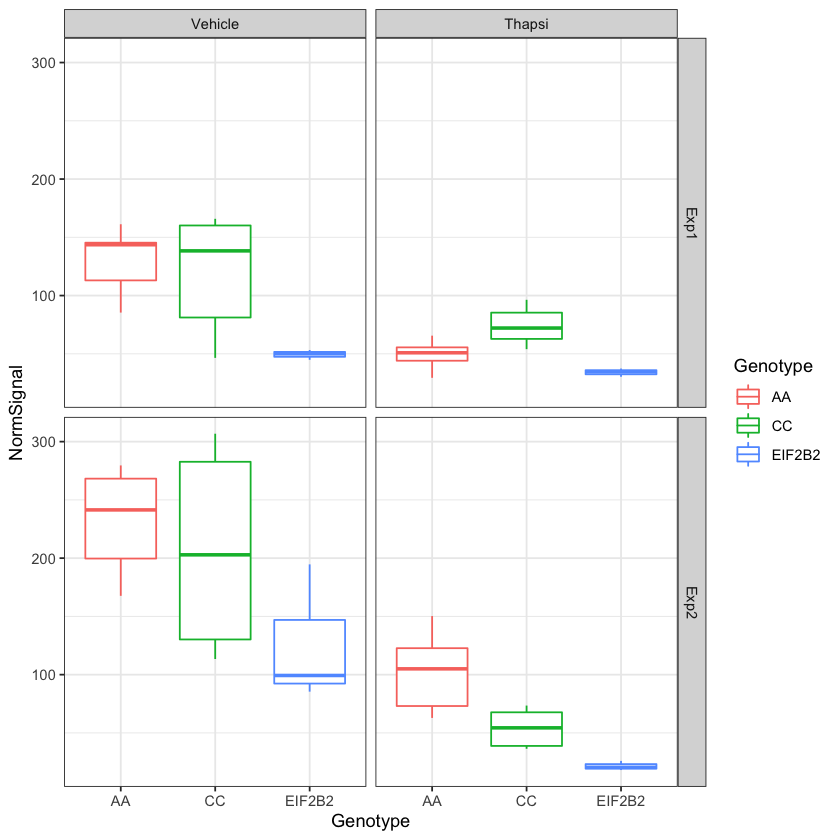

In [9]:
ggplot(df, aes(x=Genotype, y=NormSignal, col=Genotype)) + geom_boxplot() + facet_grid(rows=vars(Experiment), cols=vars(Treatment)) + theme_bw()

In [10]:
lm.full = lmer(NormSignal ~ Genotype * Treatment + (1 | Experiment/Sample), data = df)

In [11]:
fixef(lm.full)

(Intercept)                     GenotypeCC 
                       181.301                        -17.975 
                GenotypeEIF2B2                TreatmentThapsi 
                       -93.381                       -105.479 
    GenotypeCC:TreatmentThapsi GenotypeEIF2B2:TreatmentThapsi 
                         6.182                         45.359

In [12]:
ranef(lm.full)

$`Sample:Experiment`
             (Intercept)
GM20073:Exp1       3.056
GM20074:Exp2      -3.056
HG01112:Exp1      -4.712
HG01125:Exp1     -26.800
HG01142:Exp1      11.656
HG01435:Exp1      -6.636
HG01565:Exp2      37.192
HG01572:Exp2     -42.212
HG01932:Exp2      43.835
HG02260:Exp2     -12.323

$Experiment
     (Intercept)
Exp1       -19.8
Exp2        19.8

with conditional variances for “Sample:Experiment” “Experiment” 

In [13]:
summary(lm.full)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: NormSignal ~ Genotype * Treatment + (1 | Experiment/Sample)
   Data: df

REML criterion at convergence: 573.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.3906 -0.5169  0.0052  0.4474  2.3806 

Random effects:
 Groups            Name        Variance Std.Dev.
 Sample:Experiment (Intercept) 1191     34.5    
 Experiment        (Intercept) 1006     31.7    
 Residual                      1429     37.8    
Number of obs: 60, groups:  Sample:Experiment, 10; Experiment, 2

Fixed effects:
                               Estimate Std. Error      df t value    Pr(>|t|)
(Intercept)                      181.30      30.33    1.99    5.98       0.027
GenotypeCC                       -17.97      28.88    8.14   -0.62       0.551
GenotypeEIF2B2                   -93.38      35.37    8.14   -2.64       0.029
TreatmentThapsi                 -105.48      15.43   47.00   -6.84 0.000000015
Geno

In [14]:
anova(lm.full)

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
Genotype,6842,3421,2,6,2.394,0.1720015806596
Treatment,105265,105265,1,47,73.675,0.0000000000348
Genotype:Treatment,4402,2201,2,47,1.541,0.2248665709164


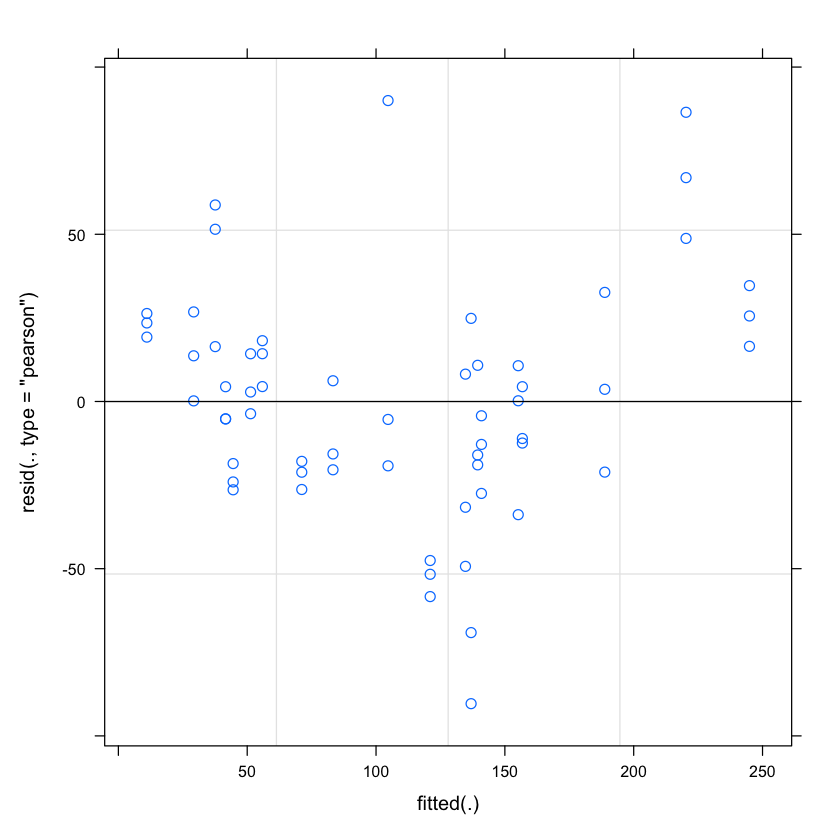

In [15]:
plot(lm.full)

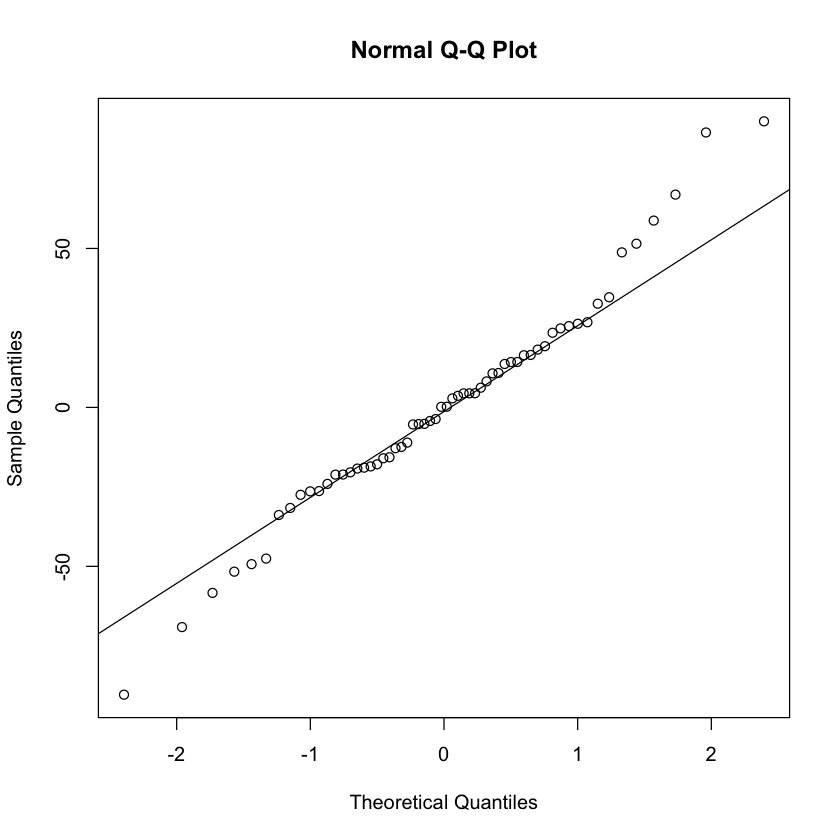

In [16]:
qqnorm(resid(lm.full))
qqline(resid(lm.full))

In [17]:
emmeans(lm.full, list(pairwise ~ Genotype | Treatment), adjust = "tukey")

$`emmeans of Genotype | Treatment`
Treatment = Vehicle:
 Genotype emmean   SE   df lower.CL upper.CL
 AA        181.3 30.3 1.99     50.2      312
 CC        163.3 30.3 1.99     32.2      294
 EIF2B2     87.9 36.6 3.79    -15.9      192

Treatment = Thapsi:
 Genotype emmean   SE   df lower.CL upper.CL
 AA         75.8 30.3 1.99    -55.3      207
 CC         64.0 30.3 1.99    -67.1      195
 EIF2B2     27.8 36.6 3.79    -76.0      132

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$`pairwise differences of Genotype | Treatment`
Treatment = Vehicle:
 2           estimate   SE   df t.ratio p.value
 AA - CC         18.0 28.9 8.14 0.623   0.8122 
 AA - EIF2B2     93.4 35.4 8.14 2.640   0.0680 
 CC - EIF2B2     75.4 35.4 8.14 2.132   0.1434 

Treatment = Thapsi:
 2           estimate   SE   df t.ratio p.value
 AA - CC         11.8 28.9 8.14 0.408   0.9131 
 AA - EIF2B2     48.0 35.4 8.14 1.358   0.4048 
 CC - EIF2B2     36.2 35.4 8.14 1.024   0.5829 

Degrees-of-free

In [18]:
emmeans(lm.full, list(pairwise ~ Treatment | Genotype), adjust = "tukey")

$`emmeans of Treatment | Genotype`
Genotype = AA:
 Treatment emmean   SE   df lower.CL upper.CL
 Vehicle    181.3 30.3 1.99     50.2      312
 Thapsi      75.8 30.3 1.99    -55.3      207

Genotype = CC:
 Treatment emmean   SE   df lower.CL upper.CL
 Vehicle    163.3 30.3 1.99     32.2      294
 Thapsi      64.0 30.3 1.99    -67.1      195

Genotype = EIF2B2:
 Treatment emmean   SE   df lower.CL upper.CL
 Vehicle     87.9 36.6 3.79    -15.9      192
 Thapsi      27.8 36.6 3.79    -76.0      132

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$`pairwise differences of Treatment | Genotype`
Genotype = AA:
 2                estimate   SE df t.ratio p.value
 Vehicle - Thapsi    105.5 15.4 47 6.835   <.0001 

Genotype = CC:
 2                estimate   SE df t.ratio p.value
 Vehicle - Thapsi     99.3 15.4 47 6.435   <.0001 

Genotype = EIF2B2:
 2                estimate   SE df t.ratio p.value
 Vehicle - Thapsi     60.1 21.8 47 2.755   0.0083 

Degrees-of-freedom me

In [19]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-apple-darwin20.4.0 (64-bit)
Running under: macOS Big Sur 11.4

Matrix products: default
BLAS:   /usr/local/Cellar/openblas/0.3.15_1/lib/libopenblasp-r0.3.15.dylib
LAPACK: /usr/local/Cellar/r/4.1.0/lib/R/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] emmeans_1.6.1   lmerTest_3.1-3  lme4_1.1-27     Matrix_1.3-3   
 [5] readxl_1.3.1    magrittr_2.0.1  forcats_0.5.1   stringr_1.4.0  
 [9] dplyr_1.0.7     purrr_0.3.4     readr_1.4.0     tidyr_1.1.3    
[13] tibble_3.1.2    ggplot2_3.3.4   tidyverse_1.3.1

loaded via a namespace (and not attached):
 [1] httr_1.4.2          jsonlite_1.7.2      splines_4.1.0      
 [4] modelr_0.1.8        assertthat_0.2.1    cellranger_1.1.0   
 [7] numDeriv_2016.8-1.1 pillar_1.6.1        backports_1.2.1    
[10] lattice_0.20-44     glue_1